In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl
import uproot3 as uproot
import os
import glob
import seaborn as sns

mpl.rcParams['figure.dpi'] = 200
from scipy.optimize import curve_fit
import scipy.stats as stats

import hiplot as hip
import mplhep as hep
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use([hep.styles.ATLAS])

from IPython.core.display import display, HTML
display(HTML(
    '<style>'
        '#notebook { padding-top:0px !important; } ' 
        '.container { width:100% !important; } '
        '.end_space { min-height:0px !important; } '
    '</style>'
))

SMALL_SIZE = 20
MEDIUM_SIZE = 24
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


%matplotlib inline

In [438]:
ofolder='/d/grid17/ln16/dselector_v3/study_unusedEnergyAndShowers/results'
os.system(f'mkdir -p {ofolder}')

0

In [3]:
def loadDF(fileName,treeName,cols):
    ''' Function to load a root file '''
    tree=uproot.open(fileName)[treeName]
    df=tree.arrays(cols,outputtype=pd.DataFrame).reset_index(drop=True)
    return df

In [4]:
def applyCut(df,sectionStr):
    tmp=df
    vars1=sectionStr.split(" ")[::3]
    mins1=[float(x) for x in sectionStr.split(" ")[1::3]]
    maxs1=[float(x) for x in sectionStr.split(" ")[2::3]]
    
    for var1,min1,max1 in zip(vars1,mins1,maxs1):
        if var1[0]=='!':
            var1=var1[1:]
            tmp=tmp[~((tmp[var1]>min1)&(tmp[var1]<max1))]
        else:
            tmp=tmp[((tmp[var1]>min1)&(tmp[var1]<max1))]
    return tmp

In [512]:
cols=["Mpi0eta","Meta","Mpi0","mandelstam_t","Ebeam",
      'cosTheta_eta_hel','cosTheta_eta_gj',
       "weightASBS","AccWeight","weightBSpi0","weightBSeta",
       "Metap","Mpi0p",'rfTime',
      'proton_z','proton_momentum','unusedEnergy','unusedShowers','pVH','chiSq','photonTheta1','photonTheta2','photonTheta3','photonTheta4',
      'photonE1','photonE2','photonE3','photonE4','mmsq',
      'run','event',
      'Ebeam_thrown','Mpi0eta_thrown',
      'isCorrectBeam','isCorrectSpect','isCorrectCombo',
      'photonSystem1','photonSystem2','photonSystem3','photonSystem4'
     ]

baseDir='/d/grid17/ln16/dselector_v3/phase1_selected_v4'
dat_df=[]
acc_df=[]
for run in ["2017_1","2018_1","2018_8"]:
    dat_df.append(loadDF(f"{baseDir}/D{run}_selected_wUnusedShowers_acc_flat.root","kin",cols))
    acc_df.append(loadDF(f"{baseDir}/F{run}_selected_wUnusedShowers_acc_flat.root","kin",cols))
dat_df=pd.concat(dat_df)
acc_df=pd.concat(acc_df)

# How does 6g reactions leak in?

In [330]:
cols=["Mpi0eta","Meta","Mpi0","mandelstam_t","Ebeam",
      'cosTheta_eta_hel','cosTheta_eta_gj',
       "weightASBS","AccWeight","weightBSpi0","weightBSeta",
       "Metap","Mpi0p",
      'proton_z','proton_momentum','unusedEnergy','pVH','chiSq','photonTheta1','photonTheta2','photonTheta3','photonTheta4',
      'photonE1','photonE2','photonE3','photonE4','mmsq',
      'Ebeam_thrown','Mpi0eta_thrown',
      'isCorrectBeam','isCorrectSpect','isCorrectCombo'
     ]

mc_sims=['a2pi','etap_to_etapipi','eta_to_3pi','f1_1285_to_etapipi']
mc={}
baseMCdir='/d/grid17/ln16/dselector_v3/study_expectedYields/zDSelectedBkgndSamples_noUE/'
rootFile='bkgndSample_recon_acc_flat.root'
for mc_sim in mc_sims:
    mc[mc_sim]=loadDF(f'{baseMCdir}/{mc_sim}/{rootFile}','kin',cols)

In [ ]:
fig,axes=plt.subplots(1,2,figsize=(14,5))

for i,var in enumerate(['Mpi0',"Meta"]):
    edges=np.linspace(dat_df_2[var].min(),dat_df_2[var].max(),50)
    for k,v in mc.items():
        tmp=v[(v['Mpi0eta']>1.04)&(v['Mpi0eta']<1.80)]
        tmp=tmp[(tmp['unusedEnergy']<0.4)]
        hep.histplot(np.histogram(tmp[var],bins=edges),ax=axes[i],label=k)
axes[1].legend(bbox_to_anchor=(1.05,1))

## Back to Data

In [580]:
selection='Mpi0eta 1.04 1.72 pVH 0.5 999 mandelstam_t 0.1 1.0 !photonTheta1 -999 2.5 !photonTheta1 10.3 11.9 !photonTheta2 -999 2.5 !photonTheta2 10.3 11.9 \
!photonTheta3 -999 2.5 !photonTheta3 10.3 11.9 !photonTheta4 -999 2.5 !photonTheta4 10.3 11.9 \
chiSq -999 13.277 unusedEnergy -999 1.0 \
photonE1 0.1 999 photonE2 0.1 999 photonE3 0.1 999 photonE4 0.1 999 \
proton_momentum 0.3 999 proton_z 52 78 mmsq -0.05 0.05'

dat_df_2=dat_df
dat_df_2=applyCut(dat_df_2,selection)
acc_df_2=acc_df
acc_df_2=applyCut(acc_df_2,selection)

## Detour and calculate the weighted t-bin center for xsec measurement

In [581]:
weighted_center_alls=[]
tmins=[0.1,0.2,0.325,0.5,0.75]
tmaxs=[0.2,0.325,0.5,0.75,1.0]
for i,tmin, tmax in zip(range(5),tmins,tmaxs):
    selectAll=(dat_df_2.mandelstam_t>tmin)&(dat_df_2.mandelstam_t<tmax)
    weighted_center_all=sum(dat_df_2.loc[selectAll,'weightASBS']*dat_df_2.loc[selectAll,'mandelstam_t'])/sum(dat_df_2.loc[selectAll,'weightASBS'])
    weighted_center_alls.append(weighted_center_all)

In [582]:
for i,f in enumerate(weighted_center_alls):
    print(f'{i} t-bin center: {f:0.4f}')

0 t-bin center: 0.1501
1 t-bin center: 0.2560
2 t-bin center: 0.4038
3 t-bin center: 0.6198
4 t-bin center: 0.8691


## Return to previous study

In [26]:
dat_df_2['id']=dat_df_2.run.apply(str)+"_"+dat_df_2.event.apply(str)
acc_df_2['id']=acc_df_2.run.apply(str)+"_"+acc_df_2.event.apply(str)+"_"+acc_df_2.Ebeam_thrown.apply(str)

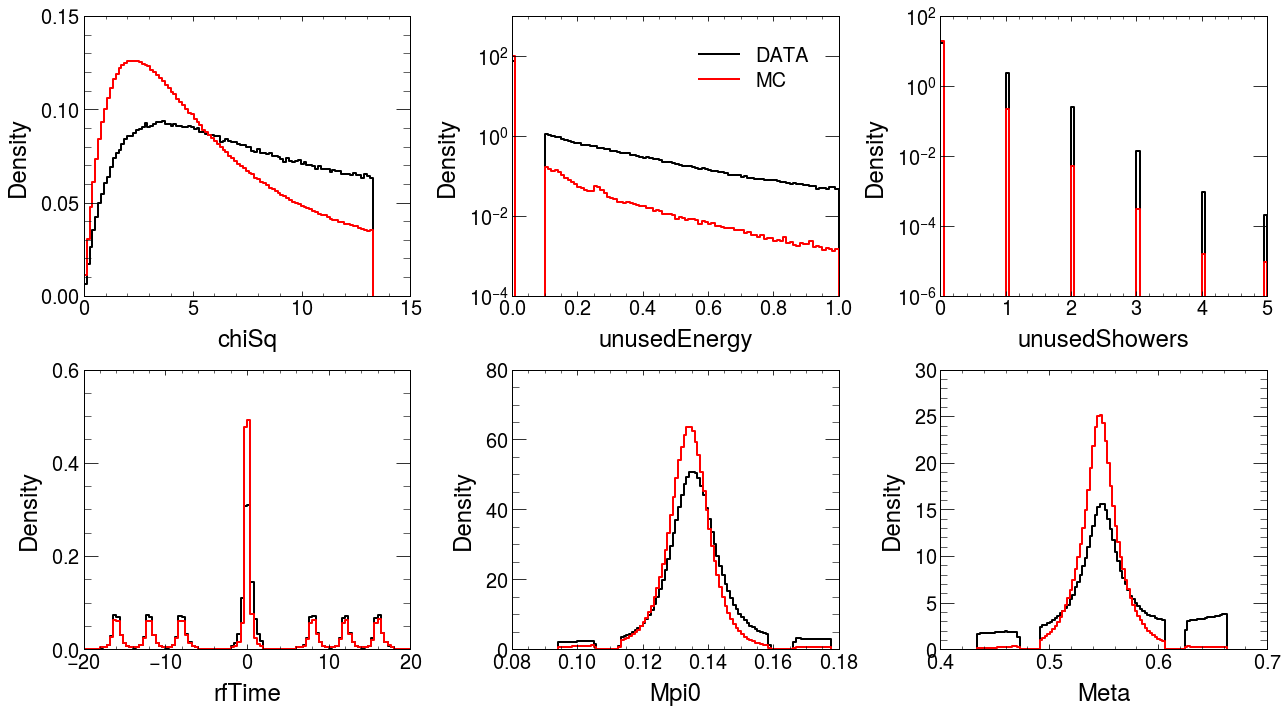

In [27]:
fig,axes=plt.subplots(2,3,figsize=(18,10))
axes=axes.flatten()
for i,var in enumerate(["chiSq",'unusedEnergy','unusedShowers',"rfTime",'Mpi0','Meta']):
    if "unused" in var:
        axes[i].set_yscale('log')
    out=np.histogram(dat_df_2[var],bins=100)
    hep.histplot(out,c='black',density=True,label='DATA',ax=axes[i])
    hep.histplot(np.histogram(acc_df_2[var],bins=out[1]),c='red',density=True,label='MC',ax=axes[i])
    axes[i].set_xlabel(var)
    axes[i].set_ylabel("Density")
axes[1].legend()
plt.tight_layout()

# combos / event 

Text(0, 0.5, 'Density')

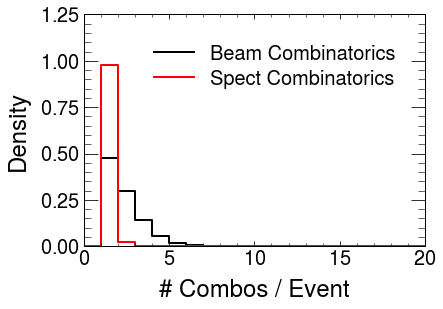

In [28]:
acc_df_3=acc_df_2[acc_df_2.isCorrectSpect]
avc=acc_df_3['id'].value_counts()
hep.histplot(np.histogram(avc.values,bins=np.linspace(0,20,21)),c='black',density=True,label='Beam Combinatorics')

acc_df_3=acc_df_2[acc_df_2.isCorrectBeam]
avc=acc_df_3['id'].value_counts()
hep.histplot(np.histogram(avc.values,bins=np.linspace(0,20,21)),c='red',density=True,label='Spect Combinatorics')
plt.legend()
plt.xlabel("# Combos / Event")
plt.ylabel("Density")

Text(0, 0.5, 'Density')

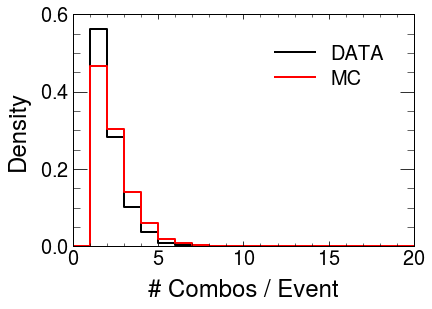

In [29]:
dat_df_3=dat_df_2#[dat_df_2.unusedEnergy<0.01]
acc_df_3=acc_df_2#[acc_df_2.unusedEnergy<0.01]

dvc=dat_df_3['id'].value_counts()
avc=acc_df_3['id'].value_counts()
hep.histplot(np.histogram(dvc.values,bins=np.linspace(0,20,21)),c='black',density=True,label='DATA')
hep.histplot(np.histogram(avc.values,bins=np.linspace(0,20,21)),c='red',density=True,label='MC')
plt.legend()
plt.xlabel("# Combos / Event")
plt.ylabel("Density")

# Understand Purity vs UE

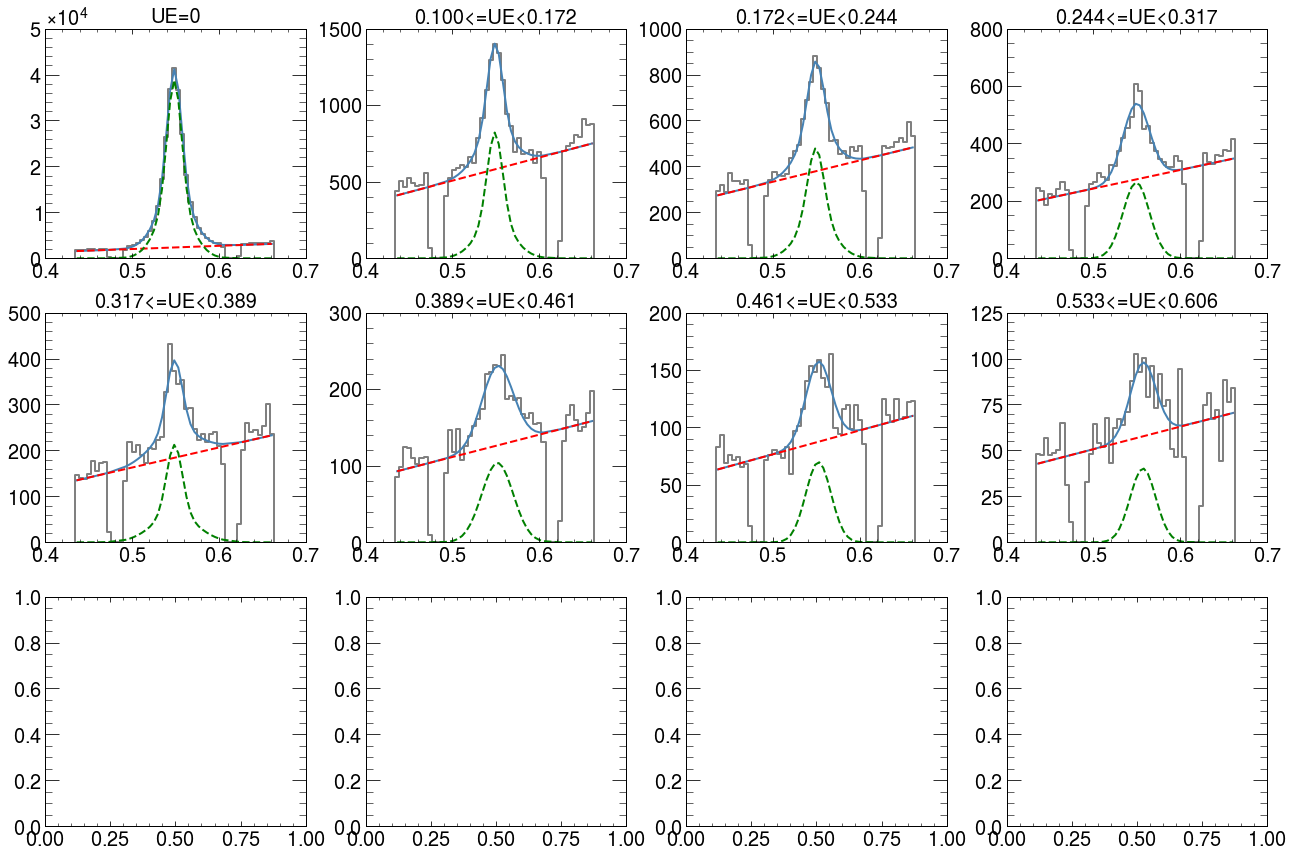

In [445]:
from scipy.optimize import curve_fit
from scipy.integrate import quad

def poly(x, a, b):#, c):
    return a+b*x#+c*x**2

def gaussian(x, A, mu, sig):
    return abs(A)*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def doublegaussian(x, A, B, mu, sig, sig2):
    return gaussian(x,A,mu,sig)+gaussian(x,B,mu,sig2)
    #return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))) + B*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig2, 2.)))

def fit(x, A, B, mu, sig, sig2, a, b):#, c):
    return doublegaussian(x,A,B,mu,sig,sig2)+poly(x,a,b)#,c)


nbins=10
lowers=np.linspace(0.1,0.75,nbins)[:nbins-1]
uppers=np.linspace(0.1,0.75,nbins)[1:]
lowers=np.insert(lowers,0,0)
uppers=np.insert(uppers,0,0.1)
As=np.linspace(5e2,0,nbins+1)
# As=[1000,500,250,125,50,50,100,50]
Bs=np.linspace(-2e3,0,nbins+1)
Cs=np.linspace(2e3,1e1,nbins+1)

def plotMetaAndFit(lower,upper,A,B,C,ax):
    tmp=dat_df_2[(dat_df_2['unusedEnergy']>=lower)&(dat_df_2['unusedEnergy']<upper)]
    out=np.histogram(tmp['Meta'],weights=tmp['AccWeight'],bins=edges)
    hep.histplot(out,color='gray',label="Data",ax=ax)
    
    yields=out[0]
    width=out[1][1]-out[1][0]
    centers=out[1][:-1]+(out[1][1]-out[1][0])/2
    minrange=0.491
    maxrange=0.606
    centers=centers[yields>0]
    yields=yields[yields>0]
#     yields=out[0][(centers>minrange)&(centers<maxrange)]
#     centers=centers[(centers>minrange)&(centers<maxrange)]
    
    popt, pcov = curve_fit(fit,centers,yields,p0=(A,A,0.55,0.01,0.05,C,B))
#     print(A,B,C)
#     print(popt)
    ax.plot(centers,fit(centers, *popt),color='steelblue',label="Gaus+Poly")
    ax.plot(centers,poly(centers, *popt[5:]),color='red',linestyle='--',label="Poly")
    ax.plot(centers,doublegaussian(centers, *popt[:5]),color='green',linestyle='--',label="Gaus")
    
    sig_yield1=quad(gaussian, popt[2]-3*abs(popt[3]), popt[2]+3*abs(popt[3]), args=(popt[0],popt[2],popt[3]))[0]
    sig_yield2=quad(gaussian, popt[2]-3*abs(popt[4]), popt[2]+3*abs(popt[4]), args=(popt[1],popt[2],popt[4]))[0]
    weightedSigma = sig_yield1/(sig_yield1+sig_yield2)*abs(popt[3])+sig_yield2/(sig_yield1+sig_yield2)*abs(popt[4])
    integral_minrange=popt[2]-3*abs(weightedSigma)
    integral_maxrange=popt[2]+3*abs(weightedSigma)
#     ax.axvline(integral_minrange,c='orange',linestyle='dotted')
#     ax.axvline(integral_maxrange,c='orange',linestyle='dotted')
    bkg_yield=quad(poly, integral_minrange, integral_maxrange, args=tuple(popt[5:]))[0]
    sig_yield=quad(doublegaussian, integral_minrange, integral_maxrange, args=tuple(popt[:5]))[0]
    tot_yield=quad(fit, integral_minrange, integral_maxrange, args=tuple(popt))[0]
    bkg_yield/=width
    sig_yield/=width
    tot_yield/=width
    purity=sig_yield/(sig_yield+bkg_yield)
    significance_sb=sig_yield/np.sqrt(sig_yield+bkg_yield)
    significance_b=sig_yield/np.sqrt(bkg_yield)
    significance_sbb=2*(np.sqrt(sig_yield+bkg_yield)-np.sqrt(bkg_yield))
    significance_cl=np.sqrt(2*(sig_yield+bkg_yield)*np.log(1+sig_yield/bkg_yield)-2*sig_yield)
#     ax.text(0.05,0.35,"Within 3$\sigma$\n--------------\nSignal Yield: %0.0fk\nBkg Yield:%0.0fk\nPurity: %0.2f\ns/sqrt(s+b): %0.0f\ns/sqrt(b): %0.0f" % (sig_yield/1000,bkg_yield/1000,
#                                                                                                                                  purity,significance_sb,significance_b),size=14,transform=ax.transAxes)
    if lower!=0:
        ax.set_title(f'{lower:0.3f}<=UE<{upper:0.3f}')
    else:
        ax.set_title(f'UE=0')
#     ax.set_ylim(0)
    return sig_yield, bkg_yield, purity, significance_sb, significance_b, significance_sbb, significance_cl, popt

fig,axes=plt.subplots(3,4,figsize=(18,12))
# fig,axes=plt.subplots(1,1,figsize=(8,5),sharex=True,sharey=True)
axes=axes.flatten()


sig_yields=[]
bkg_yields=[]
puritys=[]
significances_sb=[]
significances_b=[]
significances_sbb=[]
significances_cl=[]
popts=[]
for i, lower, upper, A, B, C, ax in zip(range(len(lowers)),lowers,uppers,As,Bs,Cs,axes):
    if i>7:
        break
    sig_yield, bkg_yield, purity, significance_sb, significance_b, significance_sbb, significance_cl, popt = plotMetaAndFit(lower,upper,A,B,C,ax)     
    sig_yields.append(sig_yield)
    bkg_yields.append(bkg_yield)
    puritys.append(purity)
    significances_sb.append(significance_sb)
    significances_b.append(significance_b)
    significances_sbb.append(significance_sbb)
    significances_cl.append(significance_cl)
    popts.append(popt)
# [axes[i].set_xlabel("$M(\gamma_3\gamma_4)$") for i in [18,19,20,21,22,23]]
# [axes[i].set_ylabel("Events") for i in [0,6,12,18]]

plt.tight_layout()

Text(0, 0.5, 'Purity in $M(\\eta)$')

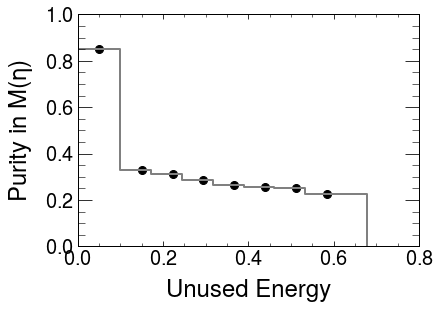

In [319]:
centers=lowers+(uppers[0]-lowers[0])/2
plt.scatter(centers[:len(puritys)],puritys,c='black')
x=np.array(puritys)
edges=np.array(list(lowers[:len(puritys)])+[uppers[len(puritys)]])
hep.histplot((x,edges),c='gray')
plt.xlabel("Unused Energy")
plt.ylabel(r"Purity in $M(\eta)$")

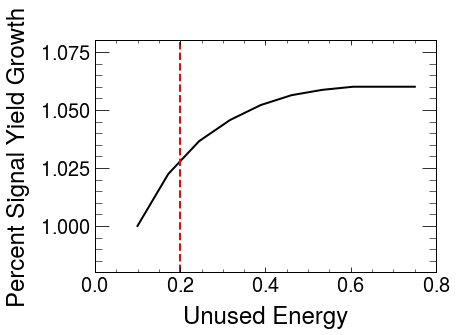

In [320]:
integrals=[]
for i in range(10):
    integrals.append(sum(sig_yields[:i+1]))
plt.plot(uppers[:10],integrals/integrals[0],c='black')
plt.xlabel("Unused Energy")
plt.ylabel("Percent Signal Yield Growth")
plt.axvline(0.2,c='red',linestyle='--')


In [321]:
uppers=np.linspace(0.1,0.4,20)
xs=[]
for upper in uppers:
    xs.append(dat_df_2.loc[dat_df_2.unusedEnergy<upper,'AccWeight'].sum())
#     xs.append(sum(dat_df_2.unusedEnergy<upper))
xs=np.array(xs)

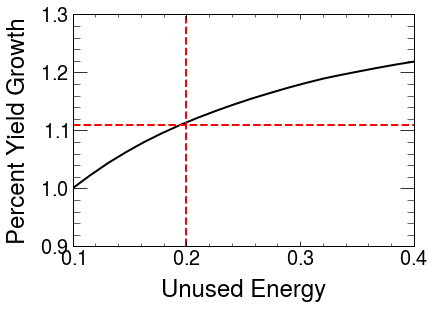

In [322]:
xs=xs/xs[0]
plt.plot(uppers,xs,c='black')
plt.xlabel("Unused Energy")
plt.ylabel("Percent Yield Growth")
plt.axvline(0.2,c='red',linestyle='--')
plt.axhline(1.11,c='red',linestyle='--')

# Plot Meta, Mpi vs UE and Unused Showers

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


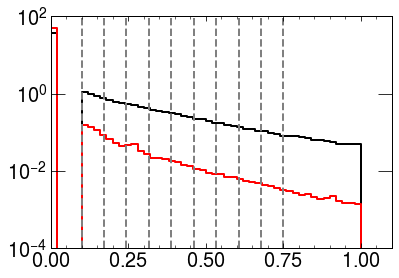

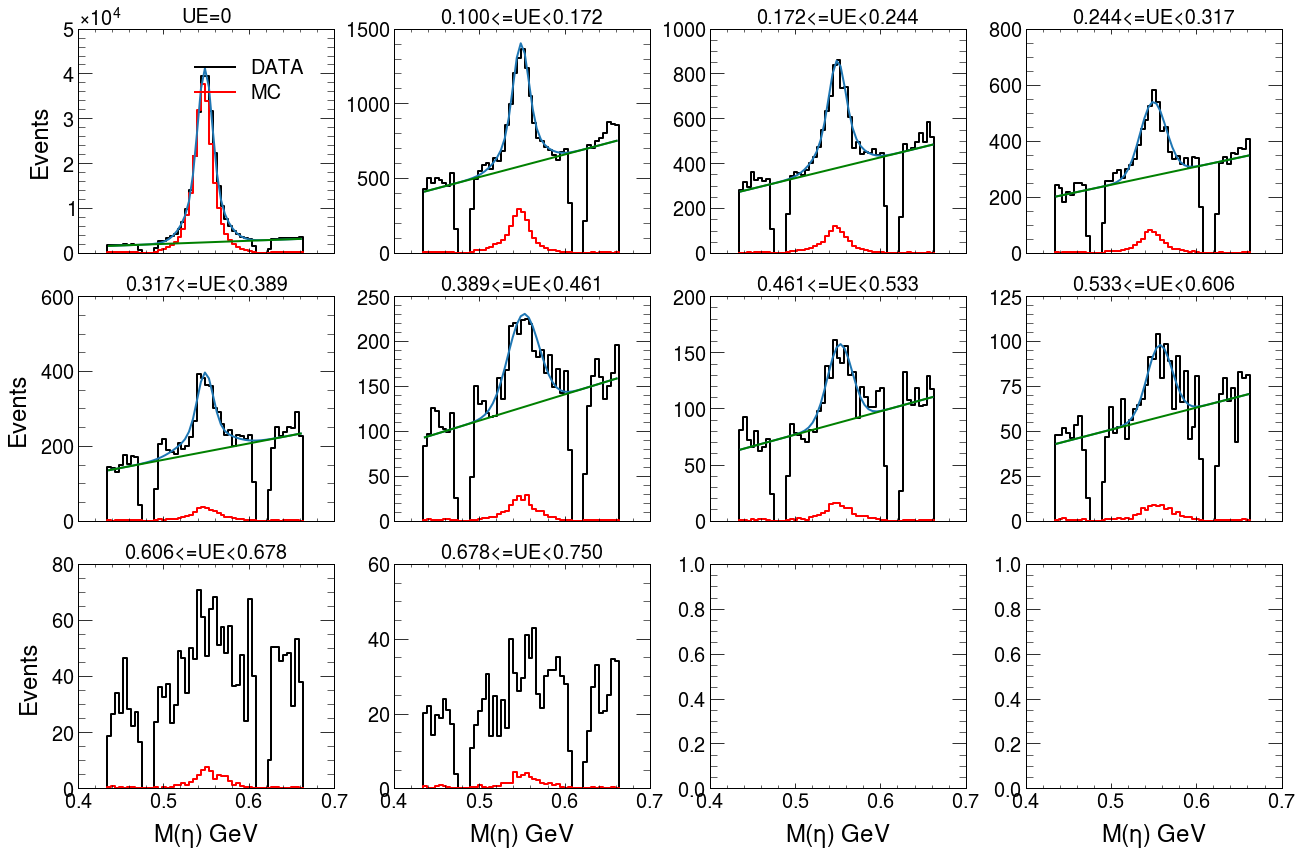

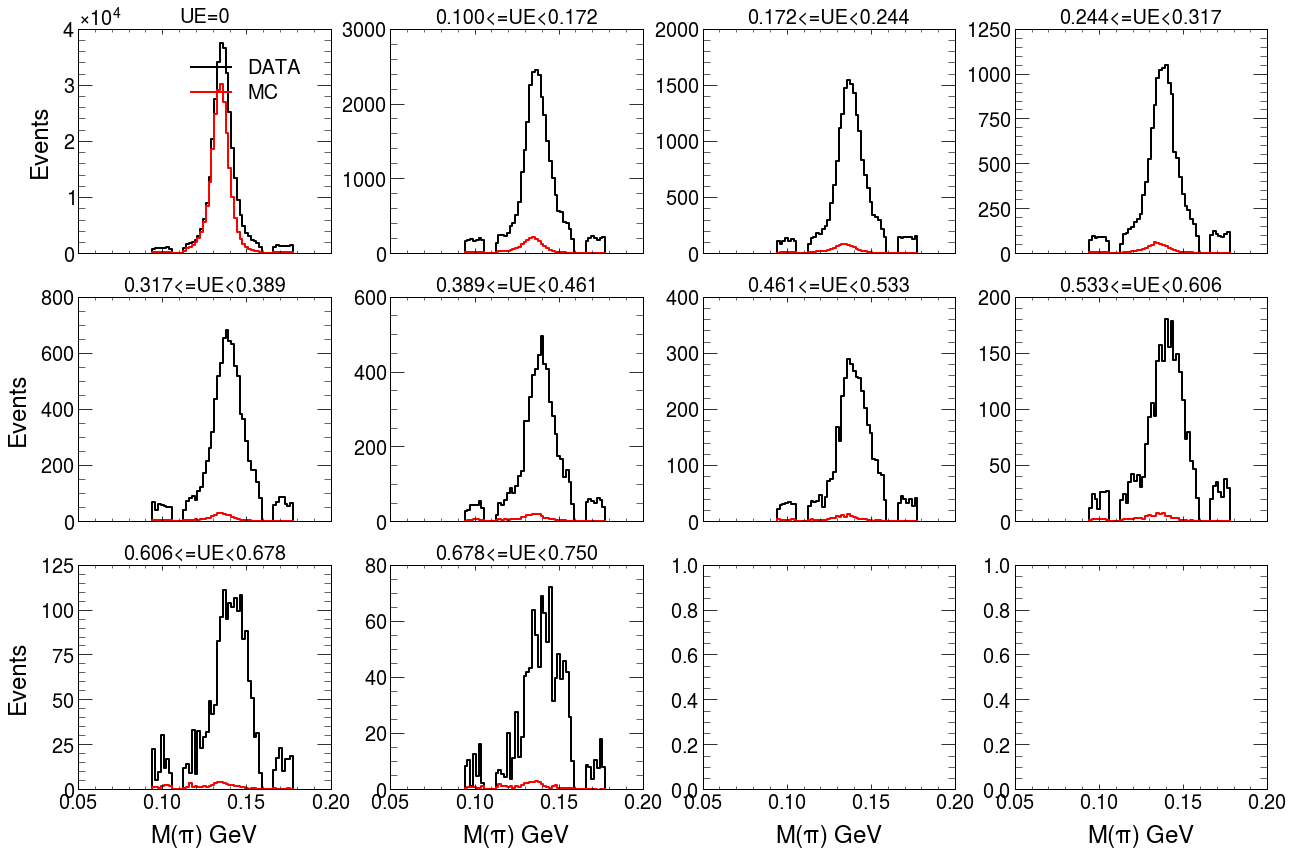

In [446]:
variable='unusedEnergy'
# lowers=np.linspace(0.0,1.0,13)[:13]
# uppers=np.linspace(0.0,1.0,13)[1:]

nbins=10
lowers=np.linspace(0.1,0.75,nbins)[:nbins-1]
uppers=np.linspace(0.1,0.75,nbins)[1:]
lowers=np.insert(lowers,0,0)
uppers=np.insert(uppers,0,0.1)
centers_ue=lowers+(lowers[1]-lowers[0])/2

plt.figure()
out=np.histogram(dat_df_2[variable],bins=50)
hep.histplot(out,c='black',density=True,label='DATA')
hep.histplot(np.histogram(acc_df_2[variable],bins=out[1]),c='red',density=True,label='MC')
for x in set(list(lowers)+list(uppers)):
    plt.axvline(x, c='gray',linestyle='--')
plt.xlim(acc_df_2[variable].min()*0.9,acc_df_2[variable].max()*1.1)
plt.yscale('log')

def plotMass_ueDep(var):
    mc_yields=[]
    fig,axes=plt.subplots(3,4,figsize=(18,12),sharex=True,sharey=False)
    axes=axes.flatten()
    for i,lower,upper in zip(range(len(lowers)),lowers,uppers):
        selection=(dat_df_2[variable]>=lower)&(dat_df_2[variable]<=upper)
        dcounts,edges=np.histogram(dat_df_2.loc[selection,var],bins=50,weights=dat_df_2.loc[selection,'AccWeight'])
        hep.histplot((dcounts,edges),c='black',
                     density=False,label='DATA',ax=axes[i])
        selection=(acc_df_2[variable]>=lower)&(acc_df_2[variable]<=upper)
        rcounts,edges=np.histogram(acc_df_2.loc[selection,var],bins=edges,weights=acc_df_2.loc[selection,'AccWeight'])
        rcounts=np.array(rcounts,dtype=float)
        if i==0:
#             scaleFactor=sum(dcounts)/rcounts.sum()
            scaleFactor=sig_yields[0]/rcounts.sum()
        rcounts*=scaleFactor
        mc_yields.append(rcounts.sum())
        hep.histplot((rcounts,edges),c='red',
                     density=False,label='MC',ax=axes[i])
        if lower!=0:
            axes[i].set_title(f'{lower:0.3f}<=UE<{upper:0.3f}')
        else:
            axes[i].set_title(f'UE=0')
        axes[i].set_ylim(0)
    if var=="Meta":
        xlabel=r'$M(\eta)$ GeV'
    if var=="Mpi0":
        xlabel=r'$M(\pi)$ GeV'    
    axes[0].legend()
    [axes[i].set_xlabel(xlabel) for i in [8,9,10,11]]
    [axes[i].set_ylabel("Events") for i in [0,4,8]]
    plt.tight_layout()
    
    return mc_yields, axes
    
mc_yields, axes=plotMass_ueDep('Meta')
edges=np.linspace(dat_df_2.Meta.min(),dat_df_2.Meta.max(),50)
centers=edges[:-1]+(edges[1]-edges[0])/2
for iax,popt in enumerate(popts):
    axes[iax].plot(centers,fit(centers, *popt),color='tab:blue',linestyle='-',label="Gaus+Poly")
    axes[iax].plot(centers,poly(centers, *popt[5:]),color='green',linestyle='-',label="Poly")
    # axes[0].plot(centers,doublegaussian(centers, *popt[:5]),color='red',linestyle='-',label="Gaus")
    
plt.savefig(f'{ofolder}/Meta_UE_yield_extraction.pdf')

plotMass_ueDep('Mpi0')
plt.savefig(f'{ofolder}/Mpi0_UE_yield_extraction.pdf')

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


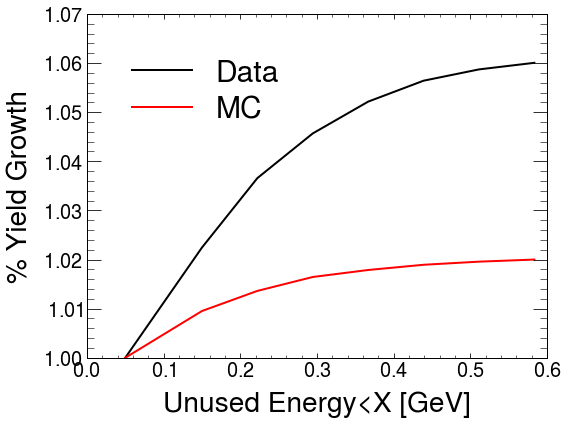

In [442]:
fig=plt.figure(figsize=(8,6))
plt.plot(centers_ue[:-2],np.cumsum(sig_yields)/sig_yields[0],c='black',label='Data')
plt.plot(centers_ue[:-2],np.cumsum(mc_yields)[:-2]/sig_yields[0],c='red',label='MC')
plt.xlabel('Unused Energy<X [GeV]',size=28)
plt.ylabel('% Yield Growth',size=28)
plt.legend(prop={'size':30})
plt.ylim(1)
plt.tight_layout()
plt.savefig(f'{ofolder}/data_mc_yield_growth.pdf')

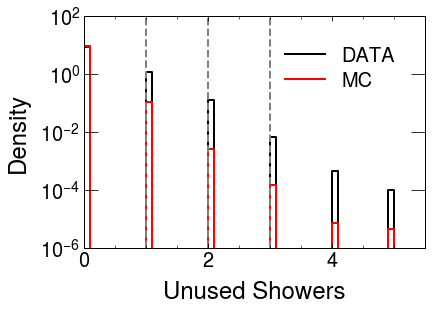

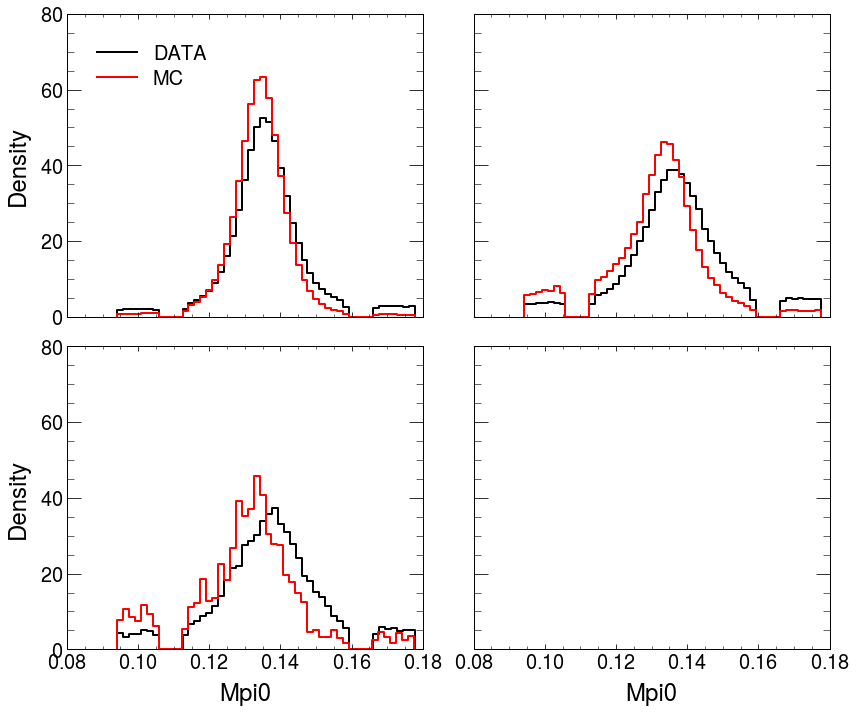

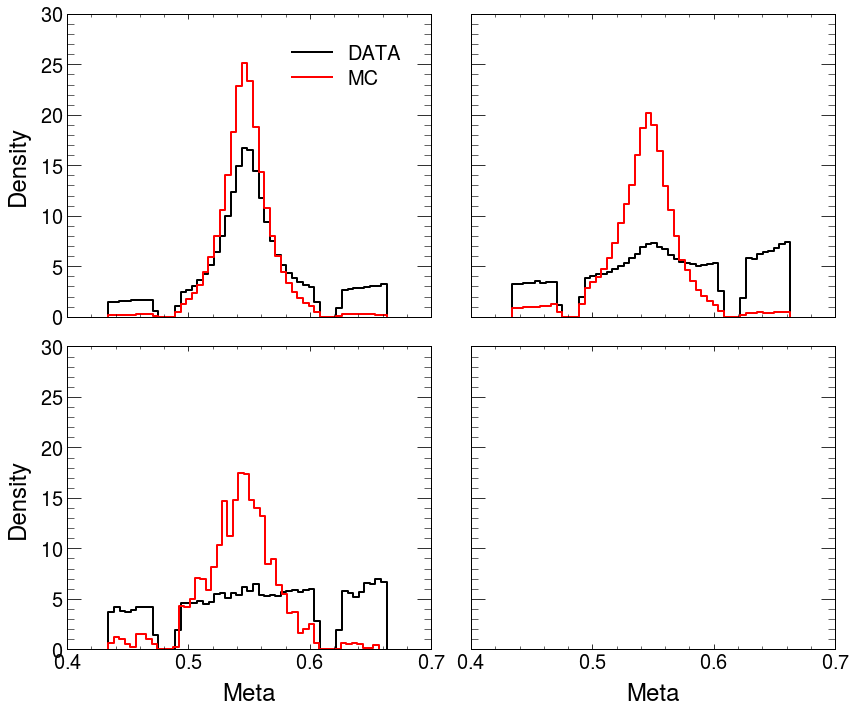

In [31]:
variable='unusedShowers'
lowers=np.arange(4)[:4]
uppers=np.arange(4)[1:]

plt.figure()
out=np.histogram(dat_df_2[variable],bins=50)
hep.histplot(out,c='black',density=True,label='DATA')
hep.histplot(np.histogram(acc_df_2[variable],bins=out[1]),c='red',density=True,label='MC')
for x in set(list(lowers)+list(uppers)):
    plt.axvline(x, c='gray',linestyle='--')
plt.xlim(acc_df_2[variable].min()*0.9,acc_df_2[variable].max()*1.1)
plt.yscale('log')
plt.xlabel("Unused Showers")
plt.ylabel("Density")
plt.legend()

def plotMass_ueDep(var):
    fig,axes=plt.subplots(2,2,figsize=(12,10),sharex=True,sharey=True)
    axes=axes.flatten()
    for i,lower,upper in zip(range(len(lowers)),lowers,uppers):
        hep.histplot(np.histogram(dat_df_2.loc[(dat_df_2[variable]>=lower)&(dat_df_2[variable]<upper),var],bins=50),c='black',density=True,label='DATA',ax=axes[i])
        hep.histplot(np.histogram(acc_df_2.loc[(acc_df_2[variable]>=lower)&(acc_df_2[variable]<upper),var],bins=50),c='red',density=True,label='MC',ax=axes[i])
    axes[0].legend()
    [axes[i].set_xlabel(var) for i in [2,3]]
    [axes[i].set_ylabel("Density") for i in [0,2]]
    plt.tight_layout()
    
plotMass_ueDep('Mpi0')
plotMass_ueDep('Meta')

In [32]:
y=dat_df_2.loc[dat_df_2.unusedShowers<2,'AccWeight'].sum()/dat_df_2.loc[dat_df_2.unusedShowers<1,'AccWeight'].sum()
print(f'Yield percentage increase after including 1 extra shower: {y}')

Yield percentage increase after including 1 extra shower: 1.1144903898239136


# t-dependence of UE?

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7f6bdfd016a0>, cbar=<matplotlib.colorbar.Colorbar object at 0x7f6bdfd01e48>)

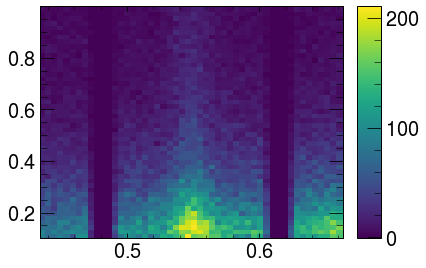

In [37]:
tmp=dat_df_2[(dat_df_2.unusedEnergy<0.4)&(dat_df_2.unusedEnergy>0.1)]
hep.hist2dplot(np.histogram2d(tmp.Meta,tmp.mandelstam_t,weights=tmp.AccWeight,bins=(50,50)))

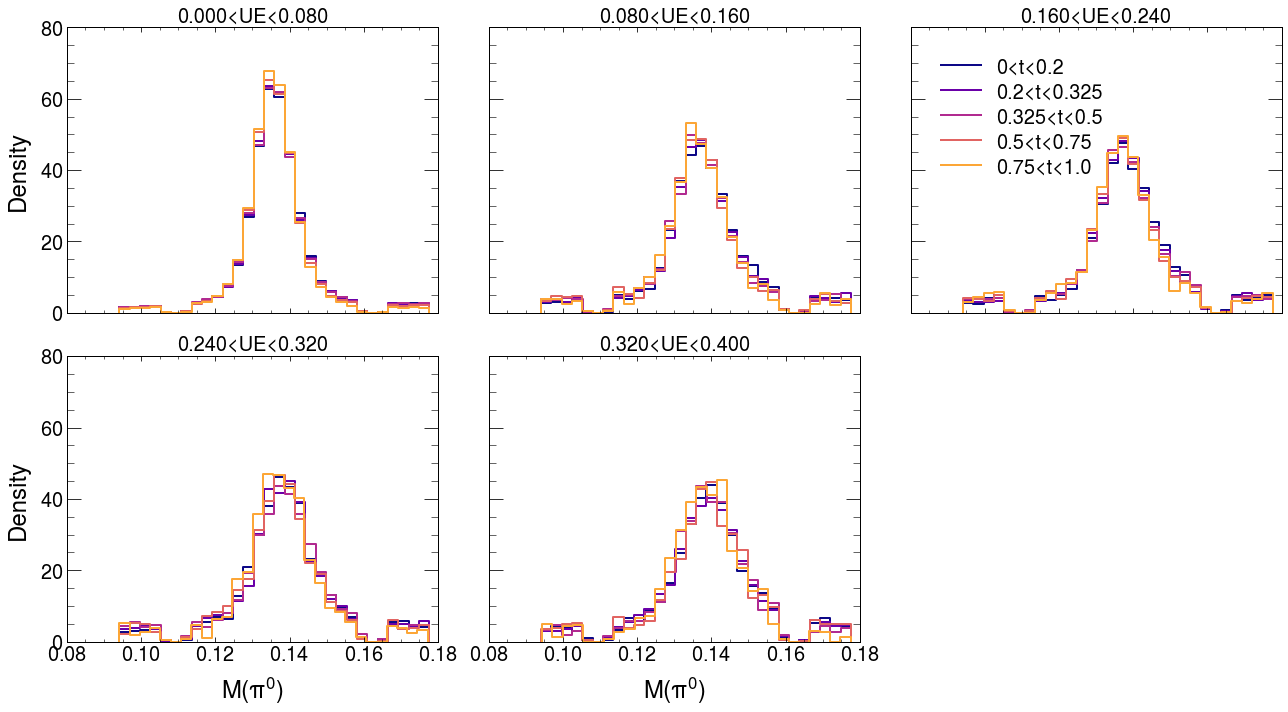

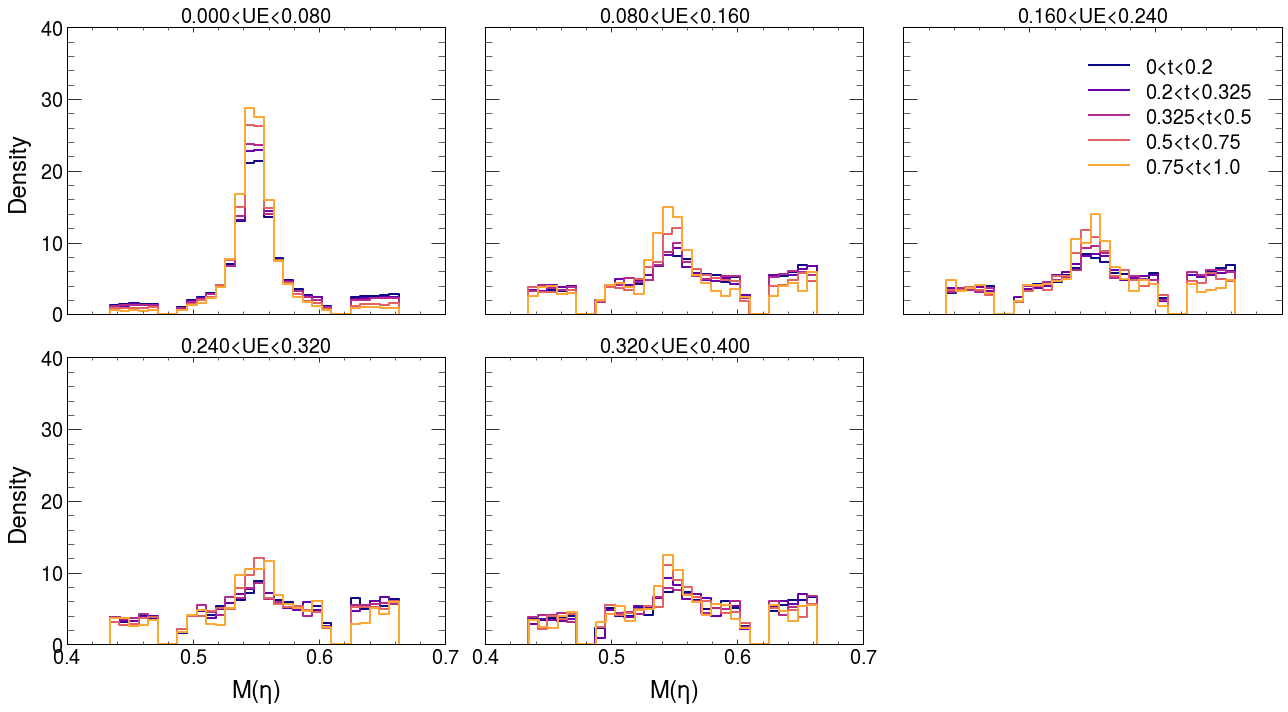

In [38]:
def plotMass_Dep2(df,var,label,label2):
    fig,axes=plt.subplots(2,3,figsize=(18,10),sharex=True,sharey=True)
    axes=axes.flatten()
    for i,lower,upper in zip(range(len(lowers)),lowers,uppers):
        for tlower,tupper,c in zip([0,0.2,0.325,0.5,0.75],[0.2,0.325,0.5,0.75,1.0],cs):
            df_tmp=df[(df.mandelstam_t>tlower)&(df.mandelstam_t<tupper)]
            df_tmp=df_tmp[(df_tmp[variable]>=lower)&(df_tmp[variable]<=upper)]
            out=np.histogram(df_tmp[var],weights=df_tmp.AccWeight,bins=30)
            hep.histplot(out,density=True,label=f'{tlower}<t<{tupper}',ax=axes[i],c=c)
        axes[i].set_title(f'{lower:0.3f}<{label2}<{upper:0.3f}')
        axes[i].set_ylim(0)
    axes[2].legend()
    [axes[i].set_xlabel(label) for i in [3,4,5]]
    [axes[i].set_ylabel("Density") for i in [0,3]]
    axes[-1].axis(False)
    plt.tight_layout()
    
variable='unusedEnergy'
lowers=np.linspace(0.0,0.4,6)[:5]
uppers=np.linspace(0.0,0.4,6)[1:]
cmap = mpl.cm.get_cmap('plasma')
cs=[cmap(x) for x in np.linspace(0,0.8,len(lowers))]
plotMass_Dep2(dat_df_2,'Mpi0',r'$M(\pi^0)$','UE')
plotMass_Dep2(dat_df_2,'Meta',r'$M(\eta)$','UE')

In [39]:
##### LOOSEN ChiSq
selection='Mpi0eta 1.04 1.72 pVH 0.5 999 mandelstam_t 0.1 1.0 !photonTheta1 -999 2.5 !photonTheta1 10.3 11.9 !photonTheta2 -999 2.5 !photonTheta2 10.3 11.9 \
!photonTheta3 -999 2.5 !photonTheta3 10.3 11.9 !photonTheta4 -999 2.5 !photonTheta4 10.3 11.9 \
chiSq -999 999 unusedEnergy -999 0.1 \
photonE1 0.1 999 photonE2 0.1 999 photonE3 0.1 999 photonE4 0.1 999 \
proton_momentum 0.3 999 proton_z 52 78 mmsq -0.05 0.05'

dat_df_4=dat_df
dat_df_4=applyCut(dat_df_4,selection)

In [111]:
##### LOOSEN PHOTON ENERGY 
selection='Mpi0eta 1.04 1.72 pVH 0.5 999 mandelstam_t 0.1 1.0 !photonTheta1 -999 2.5 !photonTheta1 10.3 11.9 !photonTheta2 -999 2.5 !photonTheta2 10.3 11.9 \
!photonTheta3 -999 2.5 !photonTheta3 10.3 11.9 !photonTheta4 -999 2.5 !photonTheta4 10.3 11.9 \
chiSq -999 13.277 unusedEnergy -999 0.1 \
photonE1 0.0 999 photonE2 0.0 999 photonE3 0.0 999 photonE4 0.0 999 \
proton_momentum 0.3 999 proton_z 52 78 mmsq -0.05 0.05'

dat_df_5=dat_df
dat_df_5=applyCut(dat_df_5,selection)

In [122]:
##### LOOSEN MMSQ 
selection='Mpi0eta 1.04 1.72 pVH 0.5 999 mandelstam_t 0.1 1.0 !photonTheta1 -999 2.5 !photonTheta1 10.3 11.9 !photonTheta2 -999 2.5 !photonTheta2 10.3 11.9 \
!photonTheta3 -999 2.5 !photonTheta3 10.3 11.9 !photonTheta4 -999 2.5 !photonTheta4 10.3 11.9 \
chiSq -999 13.277 unusedEnergy -999 0.1 \
photonE1 0.1 999 photonE2 0.1 999 photonE3 0.1 999 photonE4 0.1 999 \
proton_momentum 0.3 999 proton_z 52 78 mmsq -0.3 0.3'
dat_df_6=dat_df
dat_df_6=applyCut(dat_df_6,selection)

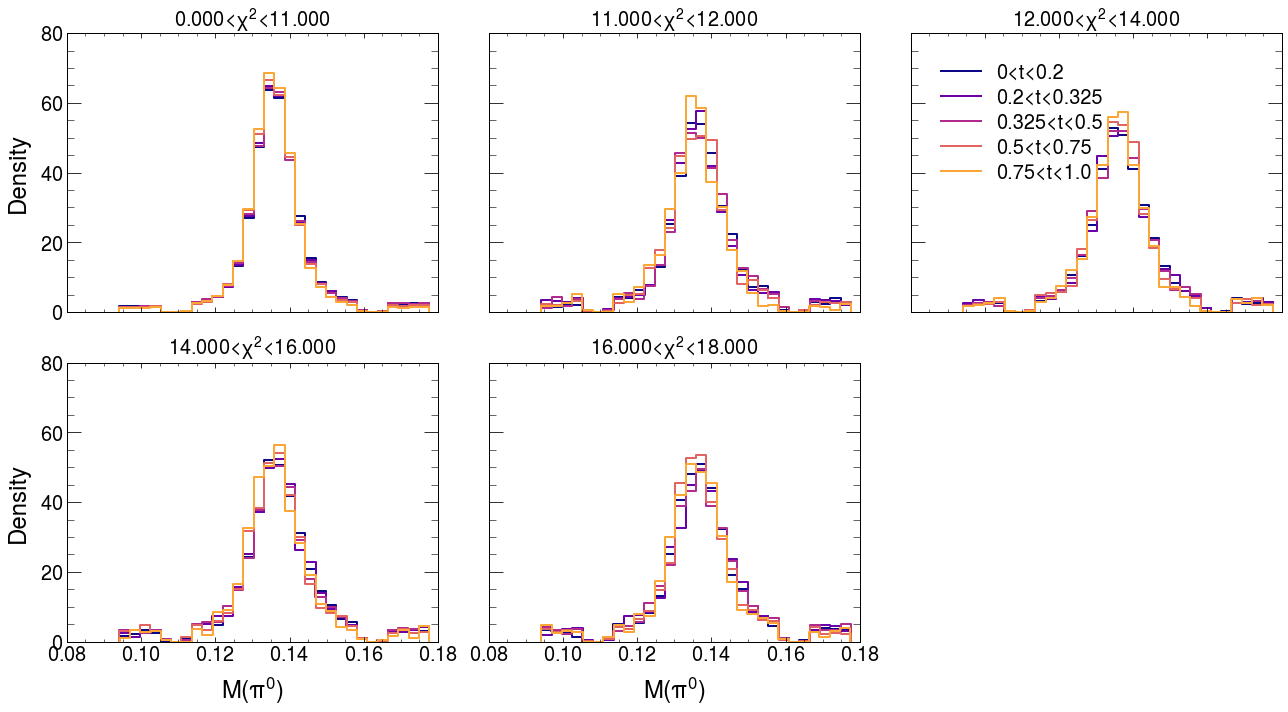

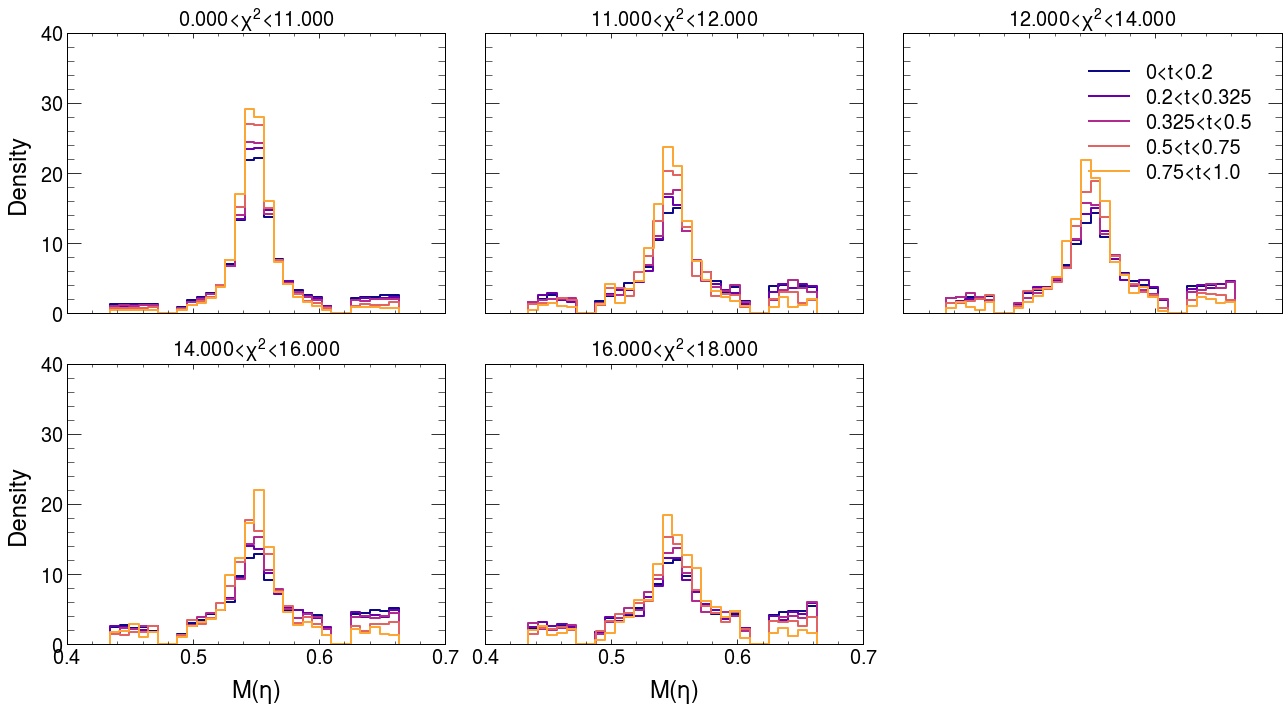

In [40]:
variable='chiSq'
lowers=np.array([0,11,12,14,16])
uppers=np.array([11,12,14,16,18])
cmap = mpl.cm.get_cmap('plasma')
cs=[cmap(x) for x in np.linspace(0,0.8,len(lowers))]
plotMass_Dep2(dat_df_4,'Mpi0',r'$M(\pi^0)$',r'$\chi^2$')
plotMass_Dep2(dat_df_4,'Meta',r'$M(\eta)$',r'$\chi^2$')

# How to calculate "yields" for systematic scans

In [126]:
def getYields(df,var,label,thresholds,normloc):
    cumulative_yields=[]
    cumulative_accIntegral=[]
    cumulative_asbsIntegral=[]
    for threshold in thresholds:
        if var.startswith('photon'):
            select=functools.reduce(lambda a, b: a&b, [df[f'{var}{i}']>threshold for i in range(1,5)])
            cumulative_yields.append(sum(select))
            cumulative_accIntegral.append(df.loc[select,'AccWeight'].sum())
            cumulative_asbsIntegral.append(df.loc[select,'weightASBS'].sum())
        elif var=='mmsq':
            select=df['mmsq'].abs()<threshold
            cumulative_yields.append(sum(select))
            cumulative_accIntegral.append(df.loc[select,'AccWeight'].sum())
            cumulative_asbsIntegral.append(df.loc[select,'weightASBS'].sum())
        else:
            cumulative_yields.append(sum(df[var]<threshold))
            cumulative_accIntegral.append(df.loc[df[var]<threshold,'AccWeight'].sum())
            cumulative_asbsIntegral.append(df.loc[df[var]<threshold,'weightASBS'].sum())
    cumulative_yields=np.array(cumulative_yields)
    cumulative_accIntegral=np.array(cumulative_accIntegral)
    cumulative_asbsIntegral=np.array(cumulative_asbsIntegral)
    
    plt.figure(figsize=(8,5))

    plt.plot(thresholds,cumulative_yields/cumulative_yields[normloc],c='black',label="Yield")
    plt.plot(thresholds,cumulative_accIntegral/cumulative_accIntegral[normloc],c='red',label='Integral(AS)')
    plt.plot(thresholds,cumulative_asbsIntegral/cumulative_asbsIntegral[normloc],c='blue',label='Integral(ASBS)')
    plt.axhline(0.9,c='gray',linestyle='--')
    plt.axhline(1.1,c='gray',linestyle='--')
    plt.xlabel(f'{label}')
    plt.ylabel(r'% Yield')
    plt.title(f'% Yield Normalized to {label}={thresholds[normloc]}')
    plt.legend()
    
    return cumulative_yields, cumulative_accIntegral, cumulative_asbsIntegral

(array([ 842828,  861700,  880158,  898116,  915631,  932725,  949741,
         966227,  982286,  998335, 1013699, 1029025, 1044150, 1058733,
        1073080, 1087259, 1101290, 1115091, 1128676, 1142206, 1155185,
        1168078, 1180885, 1193432, 1205872, 1217904, 1229893, 1241670,
        1253261, 1264510, 1275721, 1286610, 1297508, 1308336, 1318935]),
 array([294875.78, 299721.38, 304527.16, 309218.4 , 313713.8 , 317841.6 ,
        322034.66, 325911.78, 329812.8 , 333575.88, 337242.22, 340689.62,
        344091.25, 347345.47, 350515.7 , 353708.38, 356708.47, 359583.25,
        362470.28, 365329.34, 367989.72, 370676.53, 373250.  , 375758.47,
        378180.22, 380551.75, 382934.75, 385230.94, 387337.5 , 389367.8 ,
        391408.4 , 393405.1 , 395482.47, 397489.9 , 399416.62],
       dtype=float32),
 array([208663.89, 211225.1 , 213740.48, 216430.39, 218697.72, 220574.02,
        222534.48, 224356.73, 226099.8 , 227783.61, 229515.2 , 231120.56,
        232655.17, 233929.47, 235026.0

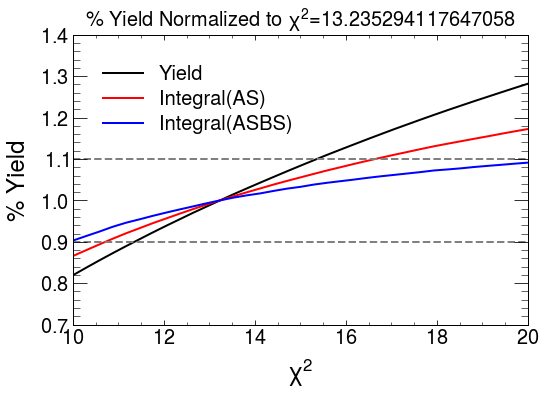

In [192]:
getYields(dat_df_4,'chiSq','$\chi^2$',np.linspace(10,20,35),11)

(array([ 937372,  973619,  995978, 1009730, 1018127, 1023345, 1026448,
        1028338, 1029440, 1030083, 1030491, 1030717, 1030886, 1030977,
        1031052, 1031106, 1031150, 1031174, 1031200, 1031217]),
 array([312845.56, 323888.62, 330754.78, 334977.78, 337446.25, 338978.  ,
        339953.9 , 340434.75, 340718.16, 340876.8 , 340996.66, 341055.38,
        341094.84, 341111.5 , 341134.56, 341146.22, 341152.44, 341165.78,
        341169.44, 341172.25], dtype=float32),
 array([215803.25, 222263.9 , 226018.02, 228335.97, 229512.17, 230232.69,
        230612.83, 230880.12, 231000.4 , 231063.48, 231156.7 , 231182.28,
        231210.95, 231227.12, 231250.66, 231261.64, 231261.6 , 231269.58,
        231274.08, 231274.94], dtype=float32))

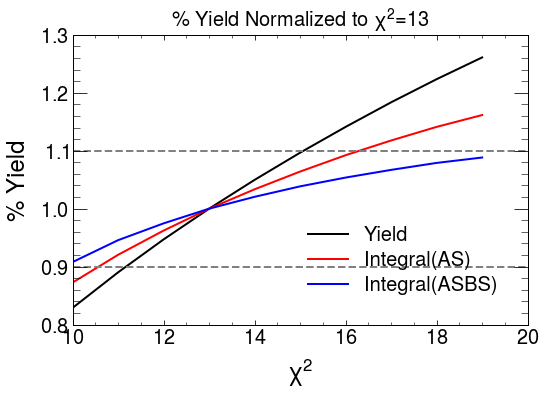

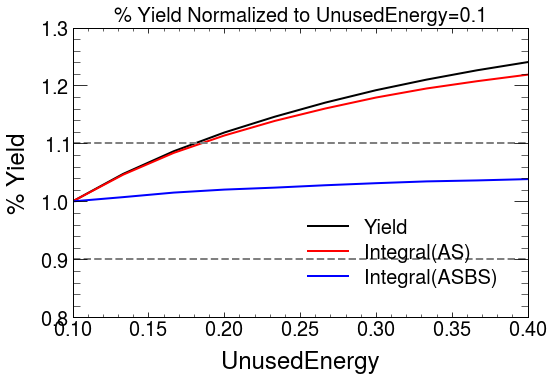

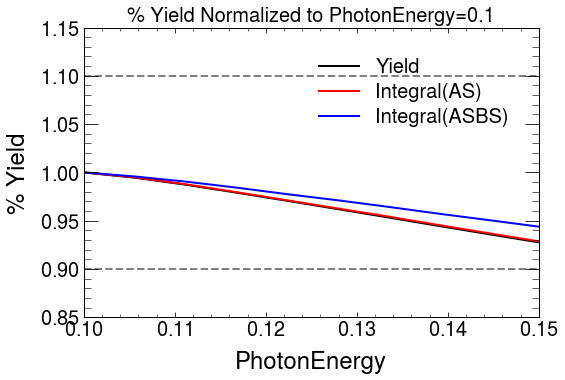

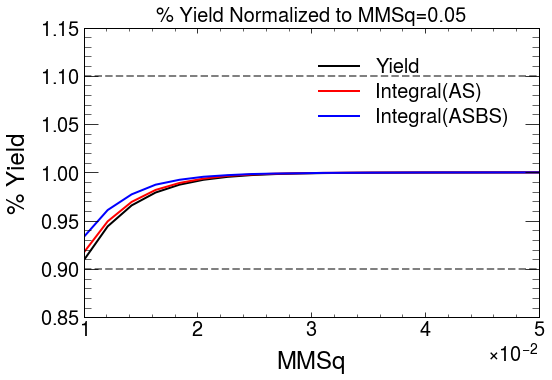

In [137]:
getYields(dat_df_4,'chiSq','$\chi^2$',np.arange(10,20),3)
getYields(dat_df_2,'unusedEnergy','UnusedEnergy',np.linspace(0.1,0.4,10),0)
getYields(dat_df_5,'photonE','PhotonEnergy',np.linspace(0.1,0.15,10),0)
getYields(dat_df_6,'mmsq','MMSq',np.linspace(0.01,0.05,20),19)

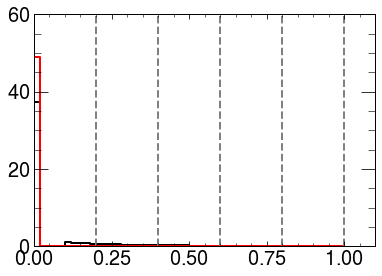

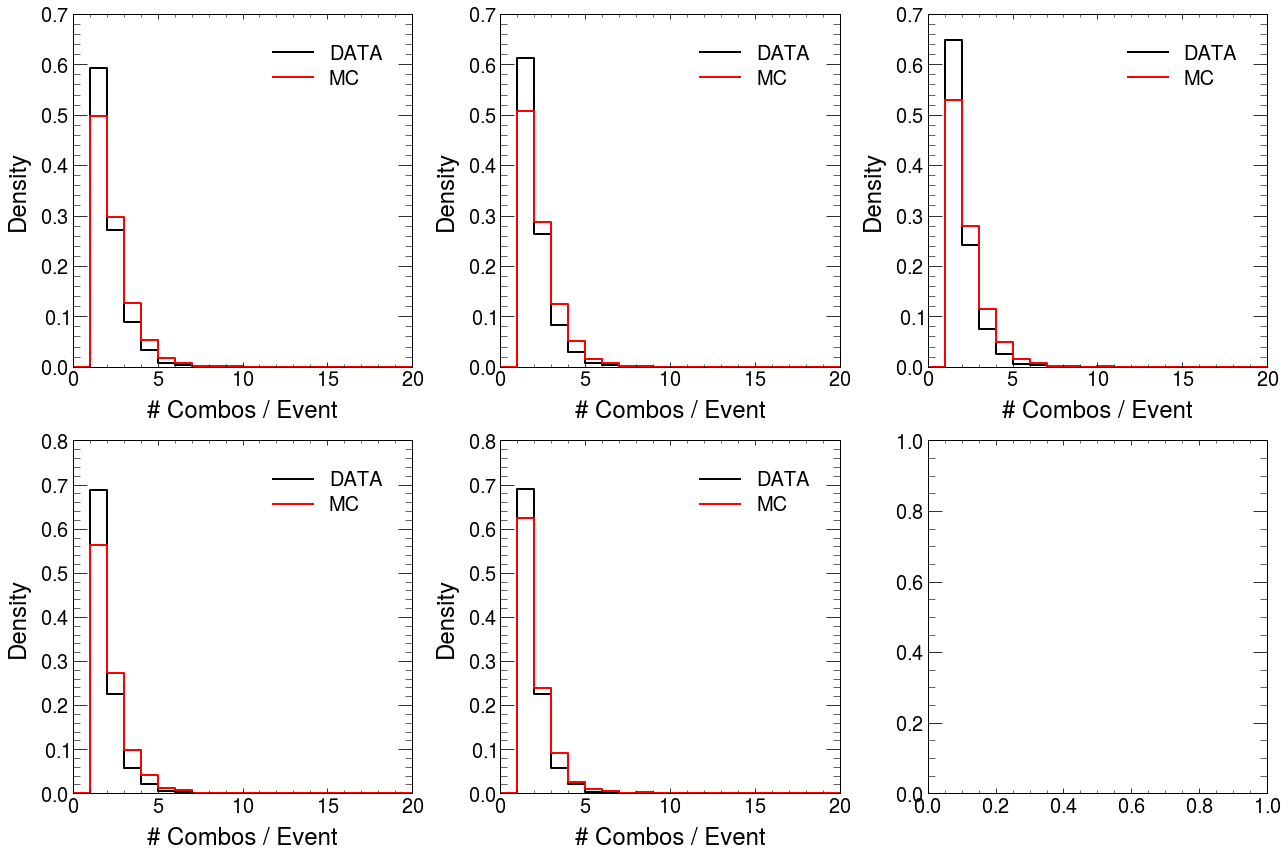

In [90]:
# variable='Mpi0eta'
# lowers=np.linspace(1.0,1.7,6)[:5]
# uppers=np.linspace(1.0,1.7,6)[1:]
# variable='mandelstam_t'
# lowers=np.linspace(0.1,1.0,6)[:5]
# uppers=np.linspace(0.1,1.0,6)[1:]
# variable='Meta'
# lowers=np.linspace(0.45,0.65,6)[:5]
# uppers=np.linspace(0.45,0.65,6)[1:]
# variable='Mpi0'
# lowers=np.linspace(0.09,0.18,6)[:5]
# uppers=np.linspace(0.09,0.18,6)[1:]
variable='unusedEnergy'
lowers=np.linspace(0.0,1.0,6)[:5]
uppers=np.linspace(0.0,1.0,6)[1:]

plt.figure()
out=np.histogram(dat_df_2[variable],bins=50)
hep.histplot(out,c='black',density=True,label='DATA')
hep.histplot(np.histogram(acc_df_2[variable],bins=out[1]),c='red',density=True,label='MC')
for x in set(list(lowers)+list(uppers)):
    plt.axvline(x, c='gray',linestyle='--')
plt.xlim(acc_df_2[variable].min()*0.9,acc_df_2[variable].max()*1.1)
# plt.yscale('log')

fig,axes=plt.subplots(2,3,figsize=(18,12))
axes=axes.flatten()

for i,lower,upper in zip(range(len(lowers)),lowers,uppers):
    dvc=dat_df_2.loc[(dat_df_2[variable]>lower)&(dat_df_2[variable]<upper),'id'].value_counts()
    avc=acc_df_2.loc[(acc_df_2[variable]>lower)&(acc_df_2[variable]<upper),'id'].value_counts()
    hep.histplot(np.histogram(dvc.values,bins=np.linspace(0,20,21)),c='black',density=True,label='DATA',ax=axes[i])
    hep.histplot(np.histogram(avc.values,bins=np.linspace(0,20,21)),c='red',density=True,label='MC',ax=axes[i])
    axes[i].legend()
    axes[i].set_xlabel("# Combos / Event")
    axes[i].set_ylabel("Density")
plt.tight_layout()
